# ControlNet Training with COCO Bounding Boxes

Train a ControlNet model using bounding boxes as spatial conditioning:
- **Spatial Conditioning**: Bounding box masks from COCO annotations
- **Text Conditioning**: COCO captions
- **Base Model**: Stable Diffusion v1.5
- **Multi-GPU Support**: Optimized for Kaggle 2×T4 GPUs

## Installation

Run this first to install required packages (compatible with Kaggle):

```bash
pip install -q diffusers==0.21.4 transformers accelerate safetensors tensorboard pycocotools
```

In [16]:
# Memory optimization utilities for Kaggle
import gc
import torch

def clear_memory():
    """Clear GPU and system memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    print("✓ Memory cleared")

def print_memory_usage():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
    
print("✓ Memory utilities loaded")

✓ Memory utilities loaded


## COCO Dataset Loader with Bounding Boxes

This dataset:
- Downloads COCO 2017 annotations automatically
- Extracts bounding boxes for all objects in each image
- Creates binary masks from bounding boxes as spatial conditioning
- Loads corresponding captions for text conditioning

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import numpy as np
import torchvision.transforms as transforms
import os
from pycocotools.coco import COCO
import requests
from tqdm import tqdm
import json
import cv2

class COCOBoundingBoxDataset(Dataset):
    def __init__(self, root_dir='./coco_data', split='train', transform=None, image_size=512, max_samples=None, download=True):
        """
        COCO Dataset with Bounding Boxes and Captions
        
        Args:
            root_dir (str): Root directory to store COCO data
            split (str): 'train' or 'val'
            transform: Optional transform to be applied on images
            image_size (int): Size to resize images to
            max_samples (int): Optional limit on number of samples to load
            download (bool): Whether to download annotations if not found
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_size = image_size
        
        # COCO 2017 URLs
        self.annotation_urls = {
            'train': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
            'val': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
        }
        
        # Setup paths
        self.ann_dir = os.path.join(root_dir, 'annotations')
        self.img_dir = os.path.join(root_dir, f'{split}2017')
        
        split_name = 'train' if split == 'train' else 'val'
        self.ann_file = os.path.join(self.ann_dir, f'instances_{split_name}2017.json')
        self.caption_file = os.path.join(self.ann_dir, f'captions_{split_name}2017.json')
        
        # Create directories
        os.makedirs(self.ann_dir, exist_ok=True)
        os.makedirs(self.img_dir, exist_ok=True)
        
        # Download annotations if needed
        if download and not os.path.exists(self.ann_file):
            print(f"Annotation file not found. Downloading COCO 2017 annotations...")
            self._download_annotations()
        
        # Check if annotation file exists
        if not os.path.exists(self.ann_file):
            raise FileNotFoundError(
                f"Annotation file not found: {self.ann_file}\n"
                f"Please download COCO 2017 annotations from:\n"
                f"http://images.cocodataset.org/annotations/annotations_trainval2017.zip\n"
                f"Extract to: {self.ann_dir}"
            )
        
        print(f"Loading COCO {split} annotations from official dataset...")
        self.coco = COCO(self.ann_file)
        
        # Load captions if available
        self.coco_caps = None
        if os.path.exists(self.caption_file):
            print(f"Loading COCO {split} captions...")
            self.coco_caps = COCO(self.caption_file)
        else:
            print(f"⚠️  Caption file not found: {self.caption_file}")
            print("Captions will not be available.")
        
        # Get all image IDs that have annotations
        print("Filtering images with bounding box annotations...")
        all_img_ids = list(self.coco.imgs.keys())
        
        self.img_ids = []
        limit = max_samples if max_samples else len(all_img_ids)
        
        for img_id in all_img_ids[:limit]:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=False)
            if len(ann_ids) > 0:  # Has at least one bounding box
                self.img_ids.append(img_id)
        
        print(f"Total images with bounding boxes: {len(self.img_ids)}")
        print(f"Images will be loaded from: {self.img_dir}")
        
        if len(self.img_ids) == 0:
            print("\n⚠️ WARNING: No images with bounding boxes found!")
    
    def _download_annotations(self):
        """Download COCO annotations"""
        import zipfile
        
        url = self.annotation_urls[self.split]
        zip_path = os.path.join(self.root_dir, 'annotations.zip')
        
        print(f"Downloading from {url}...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(zip_path, 'wb') as f:
            with tqdm(total=total_size, unit='B', unit_scale=True) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
        
        print("Extracting annotations...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(self.root_dir)
        
        os.remove(zip_path)
        print("Annotations downloaded successfully!")
    
    def _download_image(self, img_info):
        """Download a single image from COCO"""
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        if not os.path.exists(img_path):
            try:
                response = requests.get(img_info['coco_url'])
                with open(img_path, 'wb') as f:
                    f.write(response.content)
            except Exception as e:
                print(f"Error downloading {img_info['file_name']}: {e}")
                return None
        
        return img_path
    
    def get_captions(self, img_id):
        """Get text captions for an image"""
        if self.coco_caps is None:
            return []
        
        ann_ids = self.coco_caps.getAnnIds(imgIds=img_id)
        anns = self.coco_caps.loadAnns(ann_ids)
        return [ann['caption'] for ann in anns]
    
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        # Load image info
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        
        # Download image if it doesn't exist
        if not os.path.exists(img_path):
            print(f"Downloading image: {img_info['file_name']}")
            img_path = self._download_image(img_info)
            if img_path is None:
                # Return a dummy sample if download fails
                return self.__getitem__((idx + 1) % len(self))
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Get annotations (bounding boxes)
        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=False)
        anns = self.coco.loadAnns(ann_ids)
        
        # Extract bounding boxes
        bboxes = []
        for ann in anns:
            if 'bbox' in ann:
                # COCO bbox format: [x, y, width, height]
                bboxes.append(ann['bbox'])
        
        # Get captions
        captions = self.get_captions(img_id)
        
        # Create bounding box mask
        bbox_mask = self.create_bbox_mask(bboxes, width, height)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.Compose([
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])(image)
        
        bbox_mask = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor()
        ])(bbox_mask)
        
        return {
            'image': image,
            'bbox_mask': bbox_mask,
            'raw_bboxes': bboxes,
            'image_id': img_id,
            'captions': captions
        }
    
    def create_bbox_mask(self, bboxes, width, height):
        """
        Create a clear bounding box visualization with distinct rectangles
        Draws thick rectangular borders for each bounding box
        """
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Line thickness scales with image size (min 2 pixels, max 8 pixels)
        line_thickness = max(2, min(8, int(min(width, height) / 100)))
        
        for bbox in bboxes:
            x, y, w, h = bbox
            x, y, w, h = int(x), int(y), int(w), int(h)
            
            # Ensure bbox is within image bounds
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width, x + w)
            y2 = min(height, y + h)
            
            # Draw rectangle borders using OpenCV for clean lines
            cv2.rectangle(mask, (x1, y1), (x2, y2), 255, line_thickness)
        
        return mask


print("=" * 80)
print("COCO BOUNDING BOX DATASET LOADER")
print("=" * 80)
print("\nThis uses the official COCO 2017 dataset with pycocotools.")
print("Extracts bounding boxes AND text captions!")
print("\nThe dataset will:")
print("1. Download annotations automatically (~252MB)")
print("2. Download images on-demand as you access them")
print("3. Create CLEAR bounding box masks with distinct rectangles")
print("4. Cache everything in './coco_data' directory")
print("\nAlternatively, you can manually download:")
print("- Annotations: http://images.cocodataset.org/annotations/annotations_trainval2017.zip")
print("- Images: http://images.cocodataset.org/zips/train2017.zip (18GB)")
print("- Images: http://images.cocodataset.org/zips/val2017.zip (1GB)")
print("=" * 80)

# Create datasets
train_dataset = COCOBoundingBoxDataset(
    root_dir='./coco_data',
    split='train',
    image_size=512,
    max_samples=1000,  # Start with 1000 for training
    download=True
)

val_dataset = COCOBoundingBoxDataset(
    root_dir='./coco_data',
    split='val',
    image_size=512,
    max_samples=50,
    download=True
)

print(f"\n✓ Dataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Show a sample
if len(train_dataset) > 0:
    sample = train_dataset[0]
    print(f"\nSample data shapes:")
    print(f"  - Image: {sample['image'].shape}")
    print(f"  - Bbox mask: {sample['bbox_mask'].shape}")
    print(f"  - Number of bounding boxes: {len(sample['raw_bboxes'])}")
    if sample['captions']:
        print(f"  - Sample caption: \"{sample['captions'][0]}\"")
    else:
        print("  - No captions available")

COCO BOUNDING BOX DATASET LOADER

This uses the official COCO 2017 dataset with pycocotools.
Extracts bounding boxes AND text captions!

The dataset will:
1. Download annotations automatically (~252MB)
2. Download images on-demand as you access them
3. Create CLEAR bounding box masks with distinct rectangles
4. Cache everything in './coco_data' directory

Alternatively, you can manually download:
- Annotations: http://images.cocodataset.org/annotations/annotations_trainval2017.zip
- Images: http://images.cocodataset.org/zips/train2017.zip (18GB)
- Images: http://images.cocodataset.org/zips/val2017.zip (1GB)
Loading COCO train annotations from official dataset...
loading annotations into memory...
Done (t=14.28s)
creating index...
Done (t=14.28s)
creating index...
index created!
Loading COCO train captions...
loading annotations into memory...
index created!
Loading COCO train captions...
loading annotations into memory...
Done (t=1.25s)
creating index...
Done (t=1.25s)
creating index..

## Visualize Sample Data

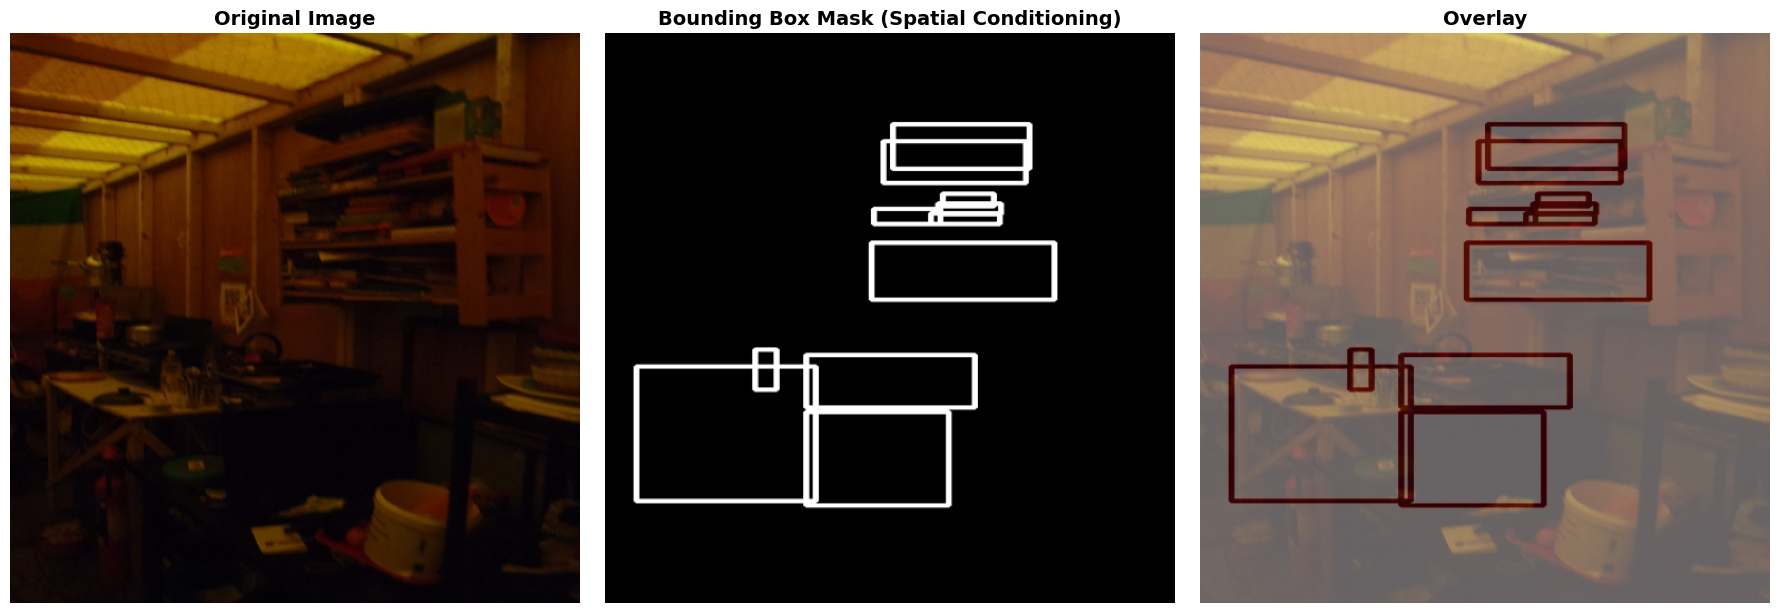

Image ID: 118113
Filename: 000000118113.jpg
Original size: 480x640
Number of objects: 11

📝 CAPTIONS:
  1. this is a very dark picture of a room with a shelf
  2. a cluttered room with a table and shelf on the wall.
  3. A view of a messy room, with shelves on the wall.
  4. A dark and cluttered storage area with wood walls.
  5. A dim lit room consisting of many objects put together. 

📦 BOUNDING BOXES (x, y, width, height):
  1. [126, 355, 18, 45]
  2. [284, 180, 43, 14]
  3. [280, 191, 53, 12]
  4. [224, 235, 154, 64]
  5. [26, 374, 151, 151]
  ... and 6 more


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get one sample
sample = train_dataset[10]
img_id = sample['image_id']

# Get image info and annotations
img_info = train_dataset.coco.loadImgs(img_id)[0]
ann_ids = train_dataset.coco.getAnnIds(imgIds=img_id)
anns = train_dataset.coco.loadAnns(ann_ids)

# Get captions
captions = sample['captions']

# Convert tensors back to displayable format
image = sample['image'].permute(1, 2, 0).cpu().numpy()
image = (image * 0.5 + 0.5)  # Denormalize from [-1, 1] to [0, 1]
image = np.clip(image, 0, 1)

bbox_mask = sample['bbox_mask'].squeeze().cpu().numpy()

# Create visualization
fig = plt.figure(figsize=(18, 6))

# Original image
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

# Bounding box mask
ax2 = plt.subplot(1, 3, 2)
ax2.imshow(bbox_mask, cmap='gray')
ax2.set_title('Bounding Box Mask (Spatial Conditioning)', fontsize=14, fontweight='bold')
ax2.axis('off')

# Overlay
ax3 = plt.subplot(1, 3, 3)
ax3.imshow(image)
ax3.imshow(bbox_mask, cmap='Reds', alpha=0.4)
ax3.set_title('Overlay', fontsize=14, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

# Display metadata
print("=" * 80)
print(f"Image ID: {img_id}")
print(f"Filename: {img_info['file_name']}")
print(f"Original size: {img_info['width']}x{img_info['height']}")
print(f"Number of objects: {len(sample['raw_bboxes'])}")
print(f"\n📝 CAPTIONS:")
if captions:
    for i, cap in enumerate(captions, 1):
        print(f"  {i}. {cap}")
else:
    print("  No captions available")
print("\n📦 BOUNDING BOXES (x, y, width, height):")
for i, bbox in enumerate(sample['raw_bboxes'][:5], 1):  # Show first 5
    print(f"  {i}. {[int(x) for x in bbox]}")
if len(sample['raw_bboxes']) > 5:
    print(f"  ... and {len(sample['raw_bboxes']) - 5} more")
print("=" * 80)

## Training Setup

In [ ]:
# Install required packages (run once)
# !pip install diffusers transformers accelerate safetensors tensorboard

import torch
import torch.nn.functional as F
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from tqdm.auto import tqdm
import os
from datetime import datetime

print("✓ Imports successful!")

In [ ]:
# Training Configuration
class TrainingConfig:
    # Model settings
    pretrained_model_name = "runwayml/stable-diffusion-v1-5"
    controlnet_conditioning_channels = 1  # Grayscale bbox mask
    
    # Training settings
    num_training_samples = 5000
    num_epochs = 5
    train_batch_size = 1  # Optimized for Kaggle
    gradient_accumulation_steps = 8
    learning_rate = 1e-5
    lr_warmup_steps = 500
    
    # Image settings
    resolution = 512
    
    # Checkpointing
    output_dir = "./controlnet_bbox_output"
    save_steps = 500
    checkpointing_steps = 1000
    
    # Logging
    logging_dir = "./logs_bbox"
    report_to = "tensorboard"
    
    # Hardware
    mixed_precision = "fp16"
    gradient_checkpointing = True

config = TrainingConfig()
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(config.logging_dir, exist_ok=True)

print(f"Output directory: {config.output_dir}")
print(f"Training {config.num_training_samples} samples for {config.num_epochs} epochs")
print(f"Batch size: {config.train_batch_size}, Gradient accumulation: {config.gradient_accumulation_steps}")
print(f"Effective batch size: {config.train_batch_size * config.gradient_accumulation_steps}")

In [ ]:
# Prepare dataset for training
print("Recreating training dataset with configured samples...")

train_dataset_full = COCOBoundingBoxDataset(
    root_dir='./coco_data',
    split='train',
    image_size=config.resolution,
    max_samples=config.num_training_samples,
    download=True
)

# Create dataloader with collate function
def collate_fn(examples):
    """Custom collate function to handle captions"""
    images = torch.stack([example['image'] for example in examples])
    bbox_masks = torch.stack([example['bbox_mask'] for example in examples])
    
    # Get first caption for each image
    captions = []
    for example in examples:
        if example['captions'] and len(example['captions']) > 0:
            captions.append(example['captions'][0])
        else:
            captions.append("objects in a scene")  # Fallback caption
    
    return {
        'images': images,
        'bbox_masks': bbox_masks,
        'captions': captions
    }

train_dataloader = DataLoader(
    train_dataset_full,
    batch_size=config.train_batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"✓ Training dataset ready: {len(train_dataset_full)} samples")
print(f"✓ Total batches per epoch: {len(train_dataloader)}")

# Clear memory after dataset creation
clear_memory()
print_memory_usage()

In [ ]:
# Initialize models
print("Loading pretrained models...")

# Load tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained(
    config.pretrained_model_name, 
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    config.pretrained_model_name, 
    subfolder="text_encoder"
)

# Load VAE
vae = AutoencoderKL.from_pretrained(
    config.pretrained_model_name, 
    subfolder="vae"
)

# Load UNet
unet = UNet2DConditionModel.from_pretrained(
    config.pretrained_model_name, 
    subfolder="unet"
)

# Initialize ControlNet from UNet
print("Initializing ControlNet...")
controlnet = ControlNetModel.from_unet(
    unet,
    conditioning_channels=config.controlnet_conditioning_channels
)

# Load noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(
    config.pretrained_model_name,
    subfolder="scheduler"
)

# Freeze VAE and text encoder - we only train ControlNet
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

print("✓ Models loaded successfully!")
print(f"  - ControlNet parameters: {sum(p.numel() for p in controlnet.parameters() if p.requires_grad):,}")
print(f"  - Text encoder (frozen): {sum(p.numel() for p in text_encoder.parameters()):,}")
print(f"  - UNet (frozen): {sum(p.numel() for p in unet.parameters()):,}")

# Clear memory after model loading
clear_memory()
print_memory_usage()

In [ ]:
# Setup optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(
    controlnet.parameters(),
    lr=config.learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps * config.gradient_accumulation_steps,
    num_training_steps=len(train_dataloader) * config.num_epochs * config.gradient_accumulation_steps,
)

print(f"✓ Optimizer configured")
print(f"  - Learning rate: {config.learning_rate}")
print(f"  - Warmup steps: {config.lr_warmup_steps}")
print(f"  - Total training steps: {len(train_dataloader) * config.num_epochs}")

In [ ]:
# Configure Accelerate for Kaggle multi-GPU
# This ensures both T4 GPUs are properly utilized
import os

# Check available GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"🔍 Detected {num_gpus} GPU(s)")
    for i in range(num_gpus):
        print(f"  - GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Set environment variables for multi-GPU training on Kaggle
    if num_gpus > 1:
        print(f"\n✓ Multi-GPU training will be enabled ({num_gpus} GPUs)")
        # Ensure CUDA devices are visible
        if 'CUDA_VISIBLE_DEVICES' not in os.environ:
            os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in range(num_gpus))
    else:
        print("\n⚠️  Only 1 GPU detected - training will use single GPU")
else:
    print("⚠️  No GPU detected - training will use CPU (VERY SLOW!)")

print("\n" + "="*80)

In [ ]:
# Initialize Accelerator for multi-GPU training
print("Initializing Accelerator...")

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
    log_with=config.report_to,
    project_dir=config.logging_dir,
)

# Enable gradient checkpointing
if config.gradient_checkpointing:
    controlnet.enable_gradient_checkpointing()

# Prepare models with accelerator
controlnet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    controlnet, optimizer, train_dataloader, lr_scheduler
)

# Move frozen models to device
unet.to(accelerator.device)
vae.to(accelerator.device)
text_encoder.to(accelerator.device)

# Set models to eval mode (only ControlNet is in training mode)
unet.eval()
vae.eval()
text_encoder.eval()

print(f"\n{'='*80}")
print(f"✓ Accelerator initialized successfully!")
print(f"{'='*80}")
print(f"  - Device: {accelerator.device}")
print(f"  - Number of processes: {accelerator.num_processes}")
print(f"  - Process index: {accelerator.process_index}")
print(f"  - Local process index: {accelerator.local_process_index}")
print(f"  - Mixed precision: {config.mixed_precision}")
print(f"  - Gradient accumulation: {config.gradient_accumulation_steps} steps")

if accelerator.num_processes > 1:
    print(f"\n🚀 MULTI-GPU TRAINING ENABLED!")
    print(f"   Training will be distributed across {accelerator.num_processes} GPUs")
    print(f"   Effective speed: ~{accelerator.num_processes}x faster")
else:
    print(f"\n⚠️  Single GPU mode")
print(f"{'='*80}\n")

## Training Loop

In [ ]:
# Training function
def train_controlnet():
    """Main training loop for ControlNet"""
    
    global_step = 0
    
    # Calculate total training steps (accounting for gradient accumulation)
    total_steps = (len(train_dataloader) * config.num_epochs) // config.gradient_accumulation_steps
    
    # Create progress bar
    progress_bar = tqdm(
        range(total_steps),
        desc="Training",
        disable=not accelerator.is_local_main_process,
    )
    
    print(f"\n{'='*80}")
    print(f"Starting ControlNet Training (Bounding Box Conditioning)")
    print(f"{'='*80}")
    print(f"Total epochs: {config.num_epochs}")
    print(f"Samples per epoch: {len(train_dataset_full)}")
    print(f"Batches per epoch: {len(train_dataloader)}")
    print(f"Gradient accumulation steps: {config.gradient_accumulation_steps}")
    print(f"Total optimizer steps: {total_steps}")
    print(f"{'='*80}\n")
    
    for epoch in range(config.num_epochs):
        controlnet.train()
        epoch_loss = 0.0
        
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(controlnet):
                # Get images and conditioning
                images = batch['images'].to(accelerator.device, dtype=torch.float32)
                bbox_conditioning = batch['bbox_masks'].to(accelerator.device, dtype=torch.float32)
                captions = batch['captions']
                
                # Encode images to latent space with VAE
                with torch.no_grad():
                    latents = vae.encode(images).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor
                
                # Sample noise
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                
                # Sample random timesteps
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,),
                    device=latents.device
                )
                timesteps = timesteps.long()
                
                # Add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                
                # Encode text prompts
                with torch.no_grad():
                    text_inputs = tokenizer(
                        captions,
                        padding="max_length",
                        max_length=tokenizer.model_max_length,
                        truncation=True,
                        return_tensors="pt",
                    )
                    text_embeddings = text_encoder(text_inputs.input_ids.to(accelerator.device))[0]
                
                # Get ControlNet output
                down_block_res_samples, mid_block_res_sample = controlnet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=text_embeddings,
                    controlnet_cond=bbox_conditioning,
                    return_dict=False,
                )
                
                # Predict noise with UNet + ControlNet
                model_pred = unet(
                    noisy_latents,
                    timesteps,
                    encoder_hidden_states=text_embeddings,
                    down_block_additional_residuals=down_block_res_samples,
                    mid_block_additional_residual=mid_block_res_sample,
                ).sample
                
                # Calculate loss
                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
                
                # Backpropagation
                accelerator.backward(loss)
                
                # Gradient clipping
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(controlnet.parameters(), 1.0)
                
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
                epoch_loss += loss.detach().item()
            
            # Update progress bar
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                
                # Logging
                if global_step % 10 == 0:
                    avg_loss = epoch_loss / (step + 1)
                    logs = {
                        "loss": loss.detach().item(),
                        "avg_loss": avg_loss,
                        "lr": lr_scheduler.get_last_lr()[0],
                        "epoch": epoch,
                    }
                    progress_bar.set_postfix(**logs)
                    accelerator.log(logs, step=global_step)
                
                # Memory monitoring
                if global_step % 100 == 0:
                    print_memory_usage()
                
                # Save checkpoint
                if global_step % config.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        save_path = os.path.join(config.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        print(f"\n✓ Checkpoint saved: {save_path}")
        
        # End of epoch summary
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"\n{'─'*80}")
        print(f"Epoch {epoch + 1}/{config.num_epochs} completed")
        print(f"Average loss: {avg_epoch_loss:.4f}")
        print(f"{'─'*80}\n")
        
        # Clear memory after each epoch
        if accelerator.is_main_process:
            clear_memory()
    
    # Save final model
    if accelerator.is_main_process:
        controlnet_save_path = os.path.join(config.output_dir, "controlnet_final")
        unwrapped_controlnet = accelerator.unwrap_model(controlnet)
        unwrapped_controlnet.save_pretrained(controlnet_save_path)
        print(f"\n{'='*80}")
        print(f"✓ Training completed!")
        print(f"✓ Final ControlNet saved to: {controlnet_save_path}")
        print(f"{'='*80}")
    
    return controlnet

print("✓ Training function ready")

In [ ]:
# Start training!
print("🚀 Starting training...")
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

trained_controlnet = train_controlnet()

print(f"\n⏰ End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## Test the Trained ControlNet

In [ ]:
# Load the trained ControlNet and create pipeline
from diffusers import StableDiffusionControlNetPipeline
from PIL import Image

# Clear memory before inference
clear_memory()
print_memory_usage()

print("Loading trained ControlNet pipeline...")

# Load the saved ControlNet
controlnet_path = os.path.join(config.output_dir, "controlnet_final")
controlnet_trained = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)

# Create inference pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    config.pretrained_model_name,
    controlnet=controlnet_trained,
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe = pipe.to(accelerator.device)

# Enable memory efficient attention (optional)
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("✓ XFormers memory efficient attention enabled")
except Exception as e:
    print(f"⚠️  XFormers not available: {e}")
    print("   (This is fine, just uses a bit more memory)")

print("✓ Pipeline ready for inference!")

In [ ]:
# Generate images using trained ControlNet
import matplotlib.pyplot as plt

# Get a test sample from validation dataset
test_sample = val_dataset[0]
test_bbox_mask = test_sample['bbox_mask']
test_caption = test_sample['captions'][0] if test_sample['captions'] else "objects in a scene"

print(f"Test prompt: \"{test_caption}\"")
print(f"Bbox mask shape: {test_bbox_mask.shape}")

# Prepare bbox mask as tensor (keep single channel!)
test_bbox_input = test_bbox_mask.unsqueeze(0).to(accelerator.device, dtype=torch.float16)
print(f"Bbox input shape: {test_bbox_input.shape}")

# Generate image
print("\nGenerating image with ControlNet...")
generator = torch.Generator(device=accelerator.device).manual_seed(42)

output = pipe(
    prompt=test_caption,
    image=test_bbox_input,
    num_inference_steps=20,
    generator=generator,
    guidance_scale=7.5,
).images[0]

# Visualize results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
orig_img = test_sample['image'].permute(1, 2, 0).cpu().numpy()
orig_img = (orig_img * 0.5 + 0.5)
orig_img = np.clip(orig_img, 0, 1)
axes[0].imshow(orig_img)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Bounding box conditioning
axes[1].imshow(test_bbox_mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title('Bounding Box Mask', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Generated image
axes[2].imshow(output)
axes[2].set_title('Generated Image', fontsize=14, fontweight='bold')
axes[2].axis('off')

# Side by side comparison
axes[3].imshow(orig_img)
axes[3].imshow(test_bbox_mask.squeeze().cpu().numpy(), cmap='Reds', alpha=0.3)
axes[3].set_title('Original + Bbox Mask', fontsize=14, fontweight='bold')
axes[3].axis('off')

plt.suptitle(f'Prompt: "{test_caption}"', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Image generation complete!")